### Вводная часть
 Условия  — несмотря на огромные вложения в рекламу, развлекательное приложения Procrastinate Pro+ последние несколько месяцев терпит убытки.

Задача — разобраться в причинах и помочь компании выйти в плюс.

Данные —    три датасета:
+ «visits_info_short.csv»  -  хранит лог сервера с информацией о посещениях сайта
+ «orders_info_short.csv»  - информацию о заказах
+ «costs_info_short.csv»  -   информацию о расходах на рекламу

Предмет исследования  –  расчет Unit-экономики приложения Procrastinate Pro+ по привлечению новых пользователей

Методы исследования: 
+ когортный анализ
+ расчет основных метрик: LTV, CAC, Retention rate, DAU, WAU, MAU и т.д. 
+ визуализация результатов анализа 

План исследования:
+ Изучить входные данные
+ Предобработка входных данных
+ Рассчитать показатели окупаемости проекта в целом
+ Определить когорты исходя из имеющихся данных – по времени, стране, каналу привлечения, устройству входа.
+ Расчет и визуализация метрик по каждой когорте отдельно.
+ Определение когорт, наиболее выделяющихся по показателям и когорт, оказывающих наибольшее влияние.
+ Категоризация когорт по окупаемости на убыточные, средние и высоко маржинальные, а также по доле пользователей.
+ Подведение итогов: выявление точек роста и составления рекомендаций для отдела маркетинга. 

### Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
# Меняем название столбцов
visits.columns = visits.columns.str.lower().str.replace(" ", "_")
orders.columns = orders.columns.str.lower().str.replace(" ", "_")
costs.columns = costs.columns.str.lower()

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()

0

In [11]:
#costs.describe()

In [12]:
#visits.describe ()

In [13]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [14]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

#### Данные готовы: 
+ пропусков и дубликатов не обнаружено 
+ названия столбцов приведены к правильному виду
+ временные метки приведены к соответствующему типу

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [15]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [16]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Затраты')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Затраты')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Затраты')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Затраты')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Затраты')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функции заданы. Переходим к анализу.

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [23]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [24]:
dt_max = profiles['dt'].max()
dt_min = profiles['dt'].min()
print(f' Минимальная {dt_min} и максимальная {dt_max} даты привлечения пользователей')  

 Минимальная 2019-05-01 и максимальная 2019-10-27 даты привлечения пользователей


#### вывод:
Нами получены данные за 6 месяцев, такой большой период, при запланированной окупаемости в 14 дней, дает хорошие возможности для анализа. По условию ТЗ дата анализа 2019-11-01, поэтому данных достаточно для анализа.

In [25]:
#Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
tabl1 = profiles.groupby('region') \
.agg({'user_id':'nunique', 'payer': ['sum', 'mean']}) 
tabl1.columns=['юзеры', 'платящие всего', 'платящие,%']
tabl1['платящие,%'] = round(tabl1['платящие,%'] *100, 4)
tabl1

,юзеры,платящие всего,"платящие,%"
region,,,
France,17450,663,3.7994
Germany,14981,616,4.1119
UK,17575,700,3.9829
United States,100002,6902,6.9019


####  вывод:
+ Пользователи  из 4 стран: США, Великобритания, Франция и Германия. 
+ США значительно лидируют по количеству пользователей приложения (примерно 100 тыс.). 
+ Также и доля платящих пользователей выше в США, почти в два раза и составляет 7%. Что очень хороший показатель!

In [26]:
# Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства
device = profiles.groupby('device') \
.agg({'user_id': 'nunique', 'payer': 'sum'}) \
.sort_values(by='payer', ascending=False)
device['share %'] = round(device.payer / device.user_id *100, 2)
device

,user_id,payer,share %
device,,,
iPhone,54479,3382,6.21
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05


#### вывод:
+ Клиенты заходят в приложение с таких устройств:  iPhone, Android, Mac и PC.
+ iPhone является самым популярным устройством среди всех клиентов со значительным отрывом (в 1,5 раза). Что объясняется большой долей пользователей из США, где iPhone контролирует более 60% рынка.
+ Доля платящих пользователей примерно одинакова для разных устройств. Для iPhone, Android и Mac составляет 6%, для PC - 5%.

In [27]:
# Таблица,количества пользователей, доли платящих для каждого канала привлечения.
channel = (profiles
    .groupby('channel')
    .agg({'user_id': 'nunique', 'payer': 'sum'})
    .sort_values(by='payer', ascending=False)
 )
channel['share %'] = round(channel.payer / channel.user_id*100, 2)
channel

,user_id,payer,share %
channel,,,
FaceBoom,29144,3557,12.20
TipTop,19561,1878,9.60
organic,56439,1160,2.06
WahooNetBanner,8553,453,5.30
AdNonSense,3880,440,11.34
RocketSuperAds,4448,352,7.91
LeapBob,8553,262,3.06
OppleCreativeMedia,8605,233,2.71
lambdaMediaAds,2149,225,10.47


#### вывод:
+ Всего источников привлечения - 11. 
+ Больше всего пользователей т.н. "органических",  тех, которые пришли не с  рекламных источников - 56,44 тыс. 
+ "Органические"  на третьем месте по количеству платящих пользователей в абсолютном выражении - 1,16 тыс. 
+ Если рассматривать только рекламные каналы, то наибольшее количество пользователей из FaceBoom и TipTop (при относительно высокой конверсии)

#### В итоге:
На основании проведенных расчетов выявлено, что приложением пользуются в большинстве случаев клиенты из Америки. Доля платящих пользователей у них выше, чем у остальных клиентов из других стран. В качестве устройств в основном используются айфоны. Владельцы продукции Apple имеют более высокую платежеспособность относительно остальных девайсов. Самыми популярными каналами привлечения пользователей являются FaceBoom и TipTop. Так же стоит отметить органический трафик, который привлек 38% всех пользователей за исследуемый период, с долей платящих клиентов 2%

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Общая сумма расходов на маркетинг

In [28]:
print('Общая сумма расходов на маркетинг', round(costs.costs.sum(), 2))

Общая сумма расходов на маркетинг 105497.3


#### Распределение затрат по рекламным источникам

In [29]:
costs1 = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
costs1

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


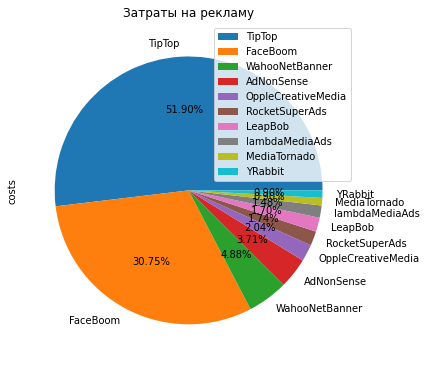

In [30]:
#  Доля затрат рекламных каналов
costs1.plot(kind='pie', autopct='%1.2f%%', figsize=(6, 7), subplots=True)
#plt.legend(loc='upper right')
plt.title('Затраты на рекламу')
plt.show()

Возможно, но я хотел подчеркнуть именно перекос в соотношении бюджетов на каналы, а не численые показатели мелких каналов. 

#### Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику


In [31]:
#Подготовка периодов
costs['dt'] = pd.to_datetime(costs['dt'])
costs['p_week'] = costs['dt'].dt.isocalendar().week
costs['p_month'] = costs['dt'].dt.month

In [32]:
costs.head()

,dt,channel,costs,p_week,p_month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


In [33]:
cost_week = costs.pivot_table(index='p_week', columns='channel', values='costs', aggfunc='sum')
cost_month = costs.pivot_table(index='p_month', columns='channel', values='costs', aggfunc='sum')

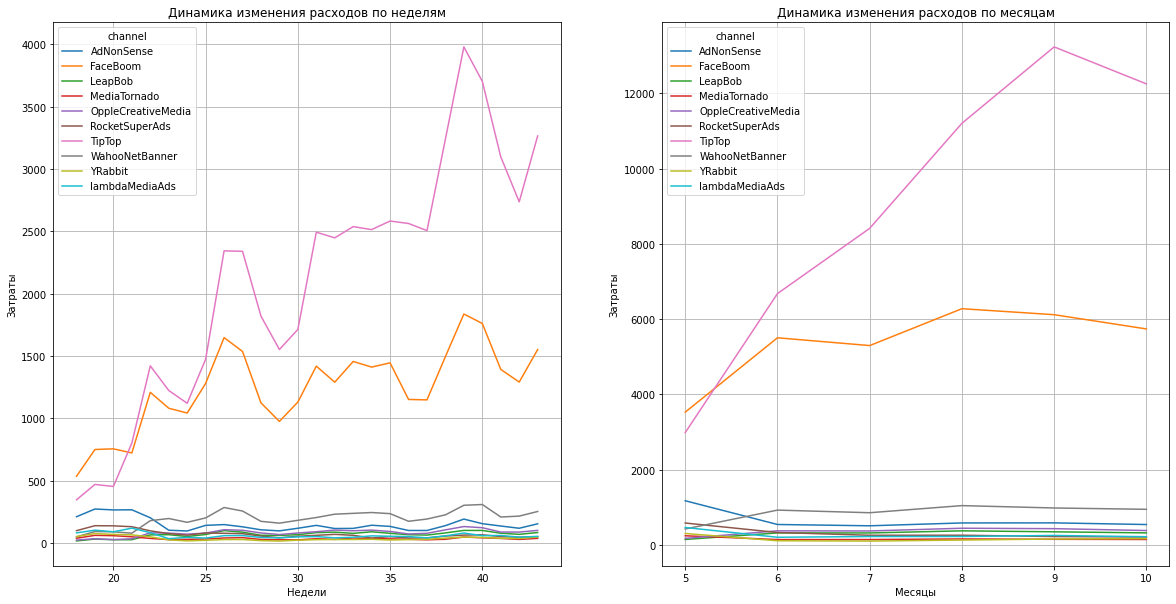

In [34]:
 # задаём размер сетки для графиков
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
cost_week.plot( grid=True, ax=ax1,
               title='Динамика изменения расходов по неделям', 
               xlabel='Недели',
               ylabel ='Затраты'
              )

cost_month.plot( grid=True, ax=ax2)
plt.xlabel('Месяцы')
plt.title('Динамика изменения расходов по месяцам')
plt.ylabel('Затраты')
plt.show()

#### Вывод по затратам
+ Затраты на два канала резко начали расти, особенно на TipTop.
+ Оба канала привлечения сильно отличаются по объему затрат, поэтому представим те же графики без них. 

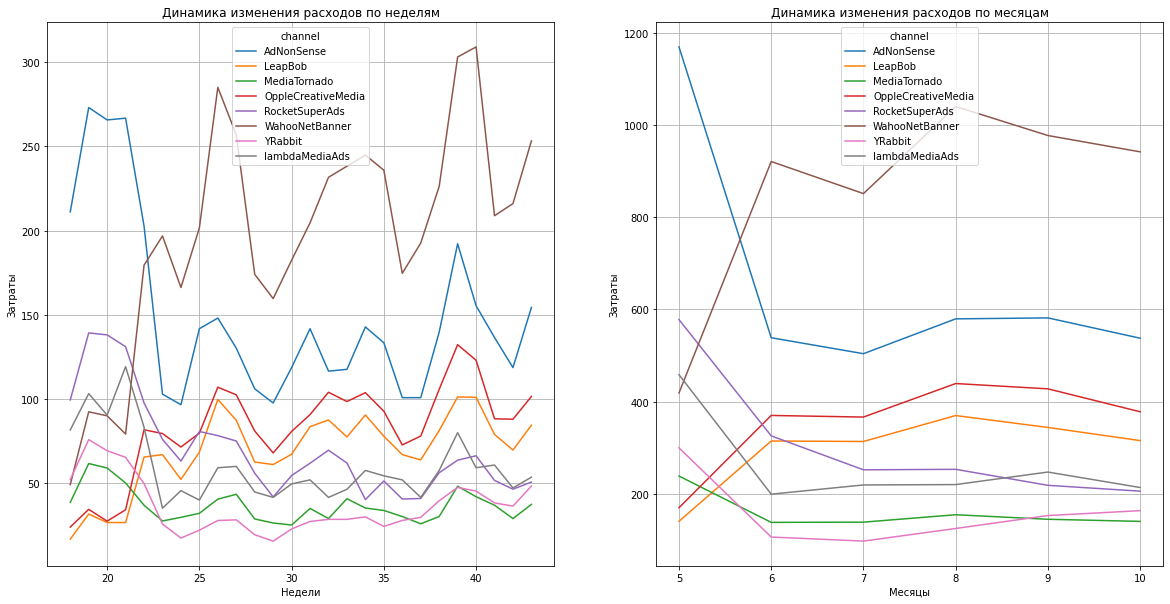

In [35]:
cost_week2 = cost_week.drop(['FaceBoom', 'TipTop'], axis=1)
cost_month2 = cost_month.drop(['FaceBoom', 'TipTop'], axis=1)
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
cost_week2.plot( grid=True, ax=ax1, 
                title='Динамика изменения расходов по неделям', 
                xlabel='Недели', ylabel ='Затраты' )

cost_month2.plot( grid=True, ax=ax2, ylabel ='Затраты')
plt.xlabel('Месяцы')
plt.title('Динамика изменения расходов по месяцам')

plt.show()

##### вывод
Из оставшихся WahooNetBanner показывает рост, а остальные каналы стабилизируются

#### Средняя стоимость привлечение одного пользователя (CAC) из каждого источника

In [36]:
# исключим пользователей с органическим трафиком из таблицы profiles
profiles = profiles.query('channel != "organic"')

In [37]:
# расчет среднего САС на одного пользователя по всем каналам
cac = profiles['acquisition_cost'].mean()
print('САС на одного пользователя по всем каналам:', round(cac, 2))

САС на одного пользователя по всем каналам: 1.13


In [38]:
# расчет среднего САС по проекту для каждого источника
cac_channels = (
    profiles.groupby('channel', as_index = False)['acquisition_cost'].mean()
    .sort_values(by='acquisition_cost', ascending = False)
)    
cac_channels.columns=['channel', 'cac']
cac_channels['cac'] = cac_channels['cac'].round(2)
cac_channels = cac_channels.set_index('channel') 
cac_channels

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


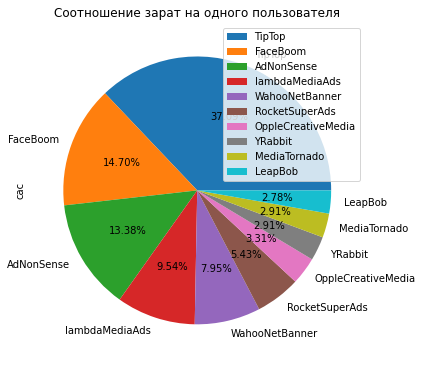

In [39]:
cac_channels.plot(kind='pie', autopct='%1.2f%%', figsize=(6, 7), subplots=True)
plt.title('Соотношение зарат на одного пользователя')
plt.show()

#####  Вывод
Самый дорогой канал  - TipTop со средним САС 2.8
По отношению  САС по всему проекту  1.13!
При этом 8 каналов ниже среднего САС

#### Подводя итог:
+ Общая сумма маркетинговых расходов - 105497.
+ Основная доля затрат приходится на каналы TipTop(52%) и FaceBoom(31%)
+ Общая сумма затрат на эти каналы растет из месяца в месяц
+ Затраты на остальные каналы меняется незначительно.
+ Но без оценки окупаемости каналов какой-либо вывод делать бессмыслено

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Анализ окупаемости рекламы c помощью графиков

In [40]:
# горизонт анализа
horizon_days = 14
# дата наблюдения
observation_date = profiles['dt'].max() 

In [41]:
# смотрим общую окупаемость
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

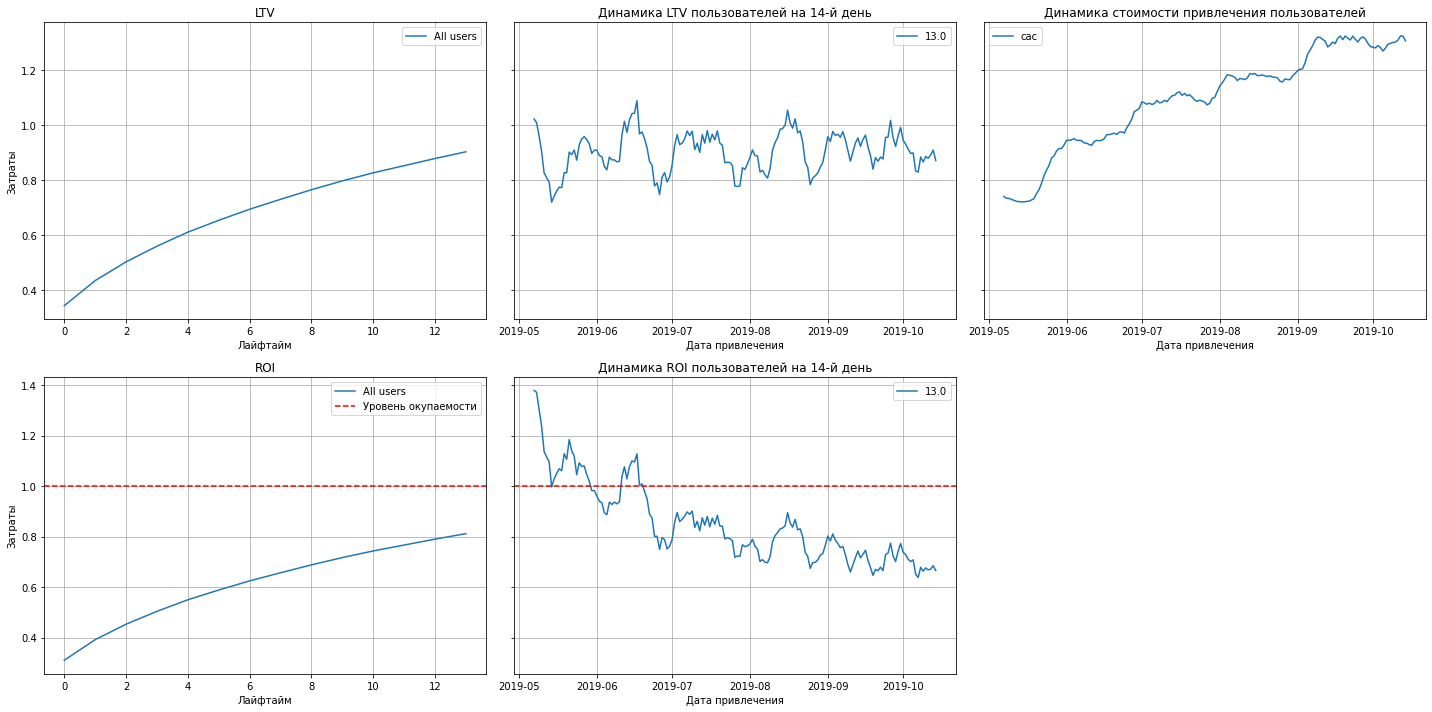

In [42]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

##### На графиках видно:
+ Реклама не окупается. 
+ Общий ROI по истечению двух недель не достиг уровня окупаемости.
+ По графику динамики LTV прослеживается колебания,  но в целом уровень стабилен. 
+ Качества пользователей не меняется.
+ Проблема в увеличении рекламного бюджета. С ростом САС, падает ROI. 

####  Конверсия и динамику её изменения. 

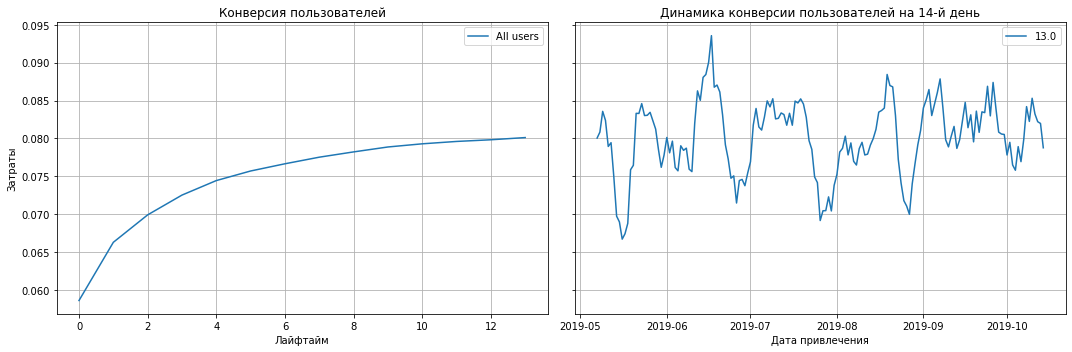

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=[])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

+ Конверсия плавно растет, что не дискредитирует данные полученные  в процессе обработки
+ Динамика конверсии сильно зависит от дня, но в среднем за период остается на одном уровне

#### Удержанием пользователей

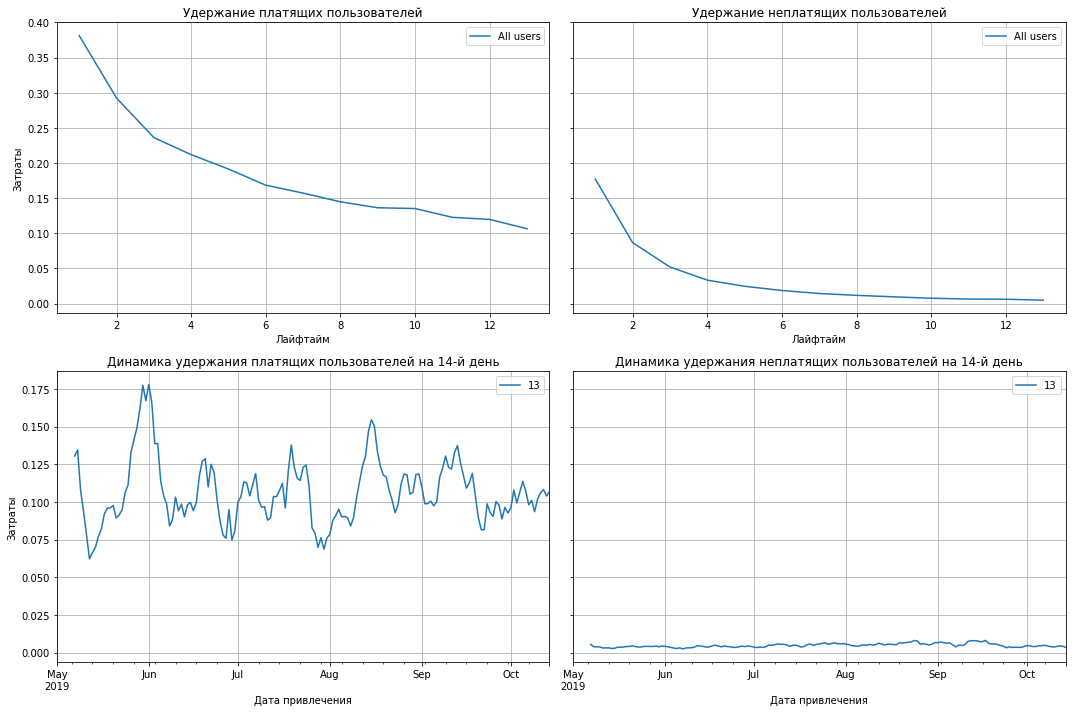

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[])

plot_retention(retention_grouped, retention_history, horizon_days)

+ Удержание платящих пользователей выше неплатящих, что логично.

#### Окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

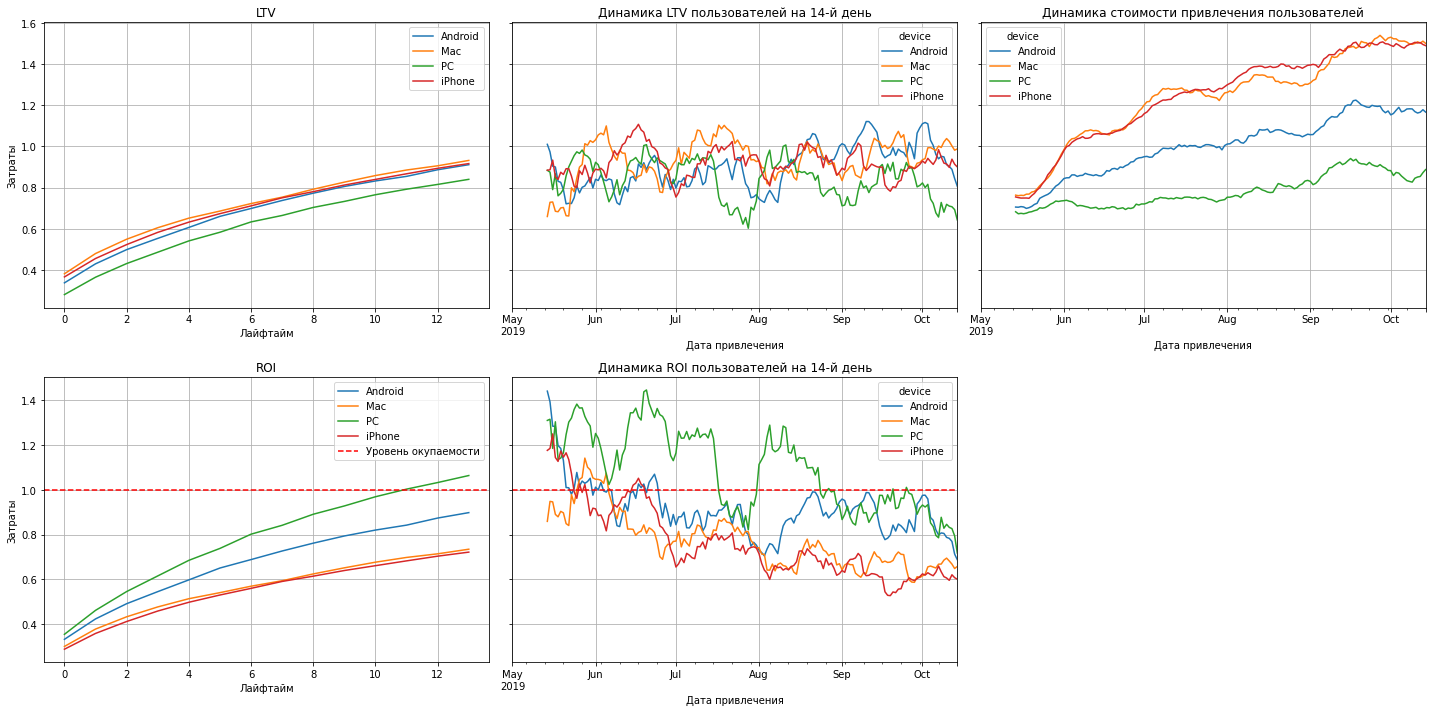

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

+ Рекламный бюджет окупается за 14 дней только у пользователей РС.
+ Для всех остальных девайсов реклама не окупается.
+ LTV стабилен. 
+ Стоимость привлечения выросла по всем устройствам, в особенности для пользователей Мас и IPhone.

#### Окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

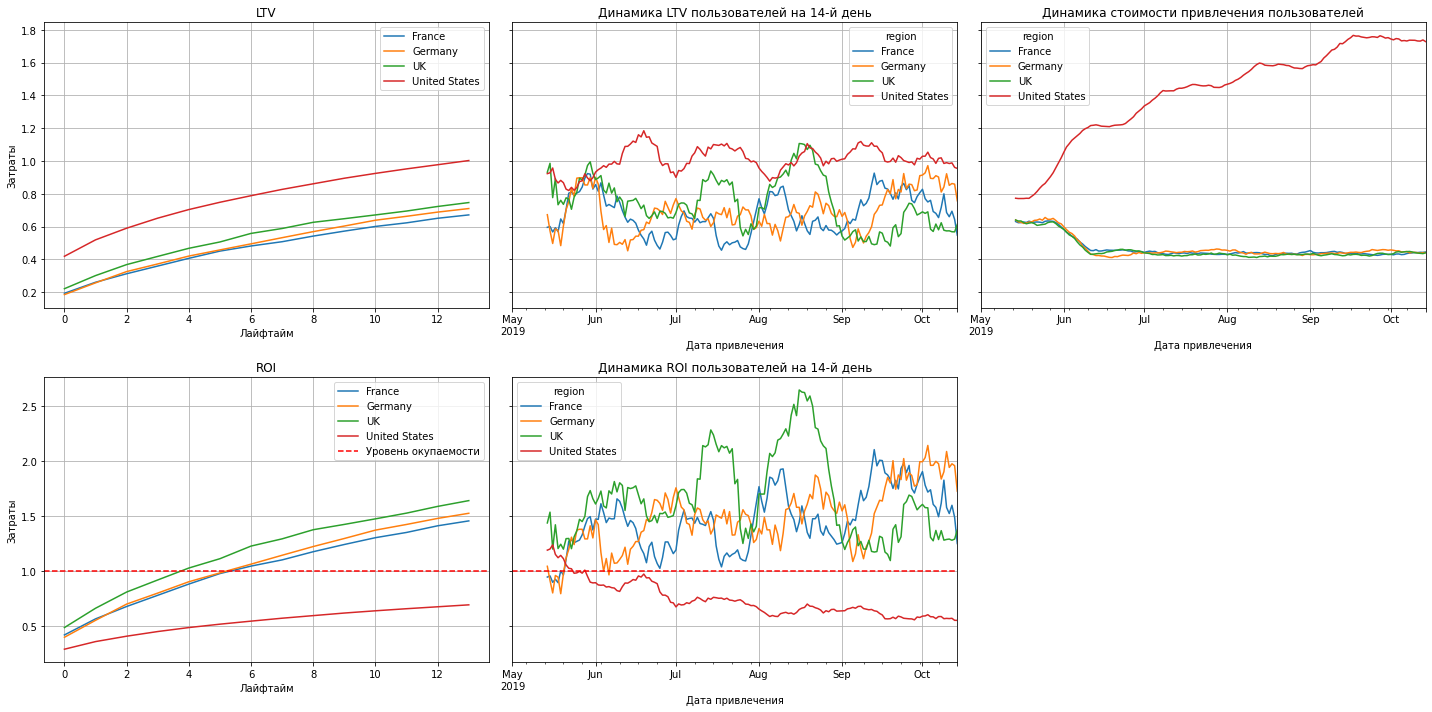

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

##### Яркое различие по регионам:
+ Регион США сильно отличается от остальных
+ Качество пользователей в США выше (судя по графикам LTV и динамики LTV)
+ Однако кратное в (2,1 раза) увеличение вложений в привличение на территории США (вероятно, изначально планировавшееся для увеличения доли "прибыльных" клиентов) привело к изменению  статуса пользователей на убыточных!
+ Учитывая то, что на пользователей из США приходится 67% от всех пользователей, эти изменения являются определяющими в доходности всей компании.
+ Инвестиции в остальные страны окупаются за 4-5 дней
+ Стоимость привлечения пользователей для них снизилась
+ Качество пользователей для всех регионов стабильна (динамика LTV) 

#### Окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

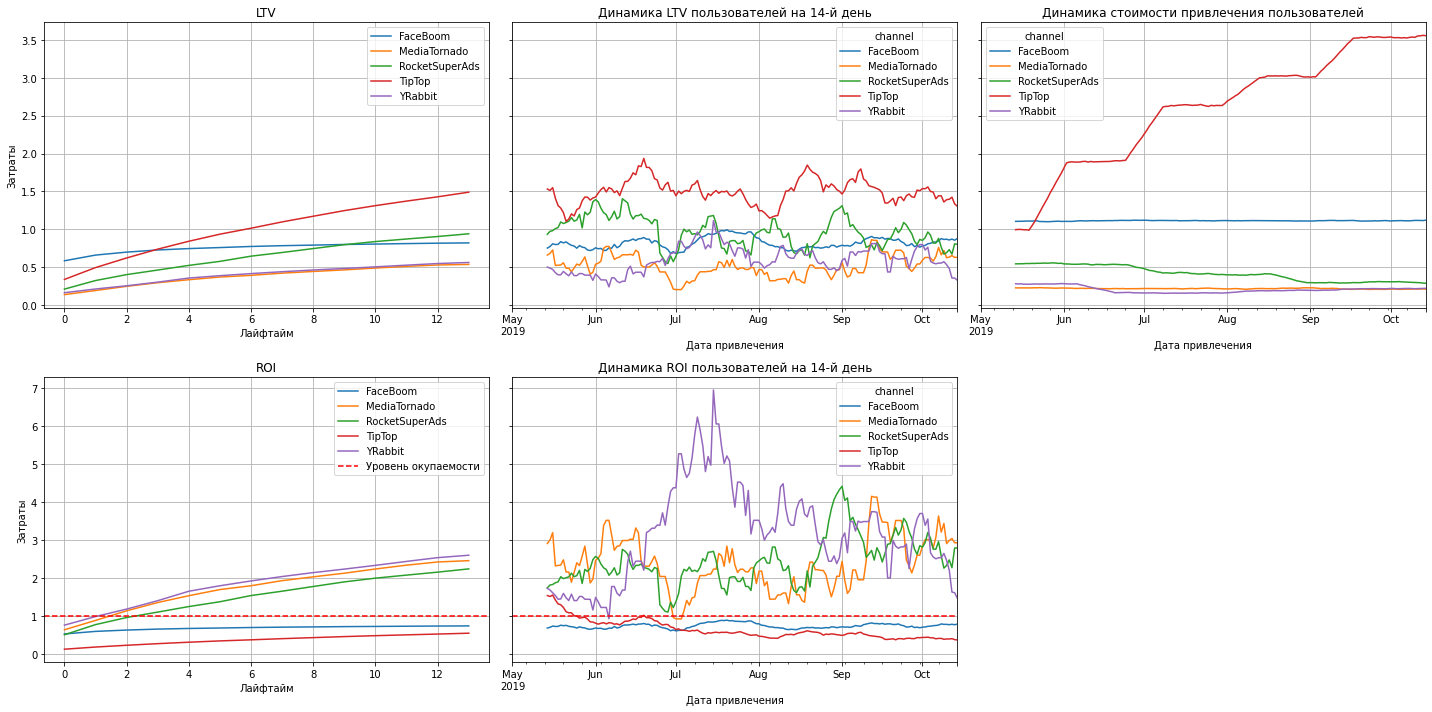

In [47]:
# По США (т.к. наиболее значимый сегмент)
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

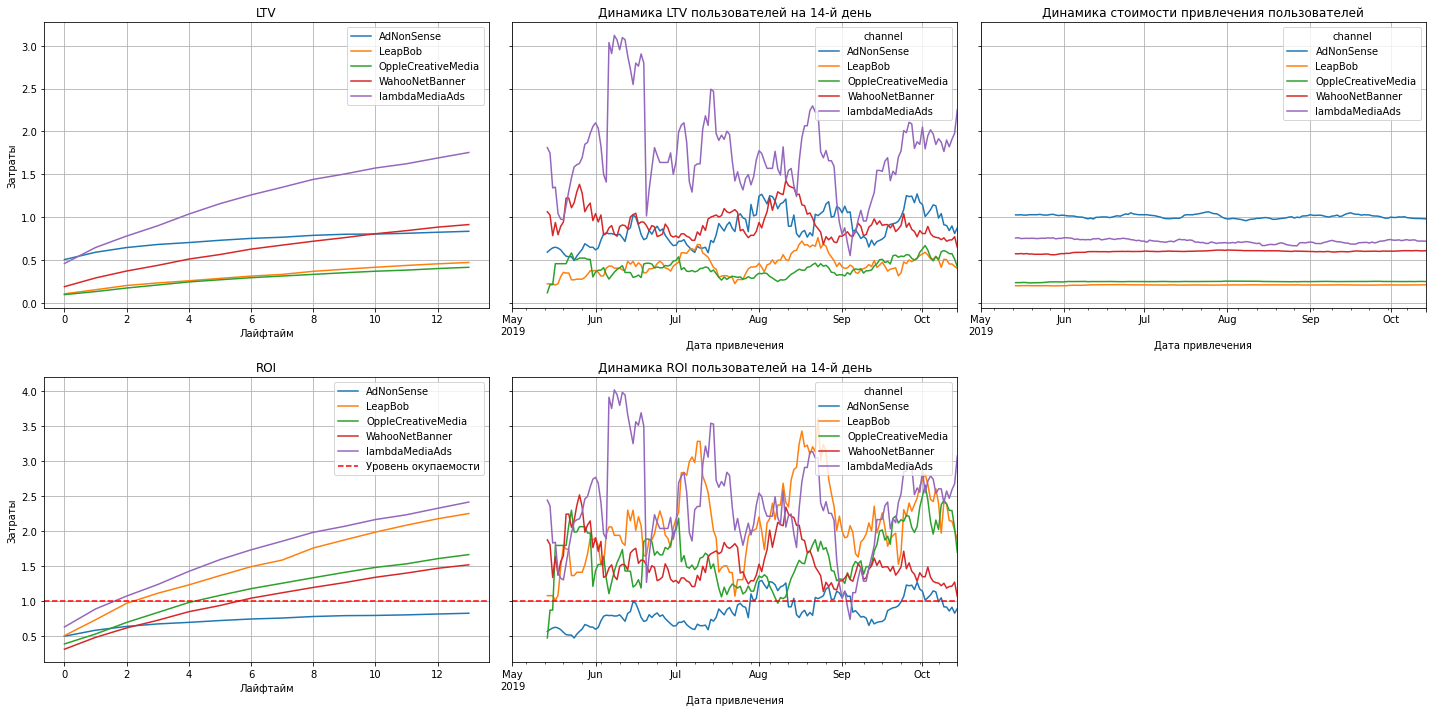

In [48]:
# По Европе (все остальные сегменты)
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region != "United States"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

#####   Различие по каналам
+ FaceBoom и TipTop в США стабильно не окупаются
+ Для Европейских стран динамика САС стабильна, однако канал AdNoNSense за 14 дней не окупается
+ Хороший показатель и динамику LTV имеет канал lambdaMediaAds.Окупаемость этого источника выше остальных и составляет менее 2-х дней.
+ FaceBoom и TipTop имеют многократно большие бюджеты
+ Динамика САС для TipTop быстро растет, что отчетливо коррелирует с ростом убыточности.
+ Показтельно выдающийся , но временный рост ROI для канала YRabbit с июня по август. Из-за снижения САС и присутсвия эффекта инерции.

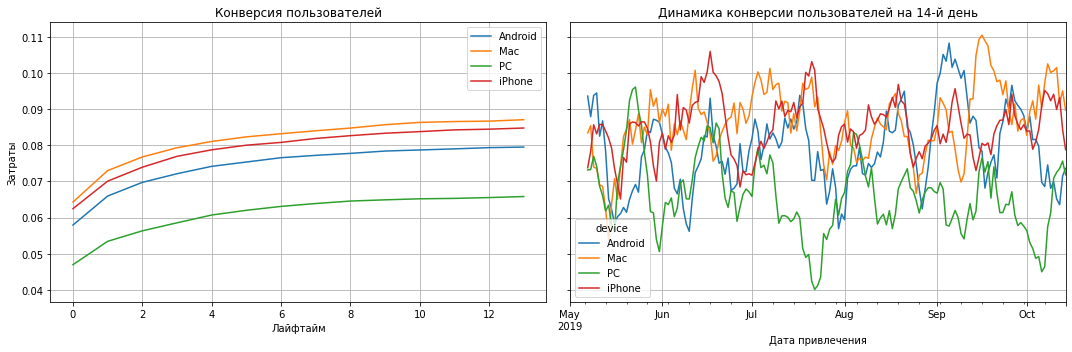

In [49]:
# конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи Mac и IPhone конвертируются хорошо. У пользователей РС конверсия значительно хуже.
Возможно связано с техническими недоработками оформления заказа именно для десктопной версии приложения

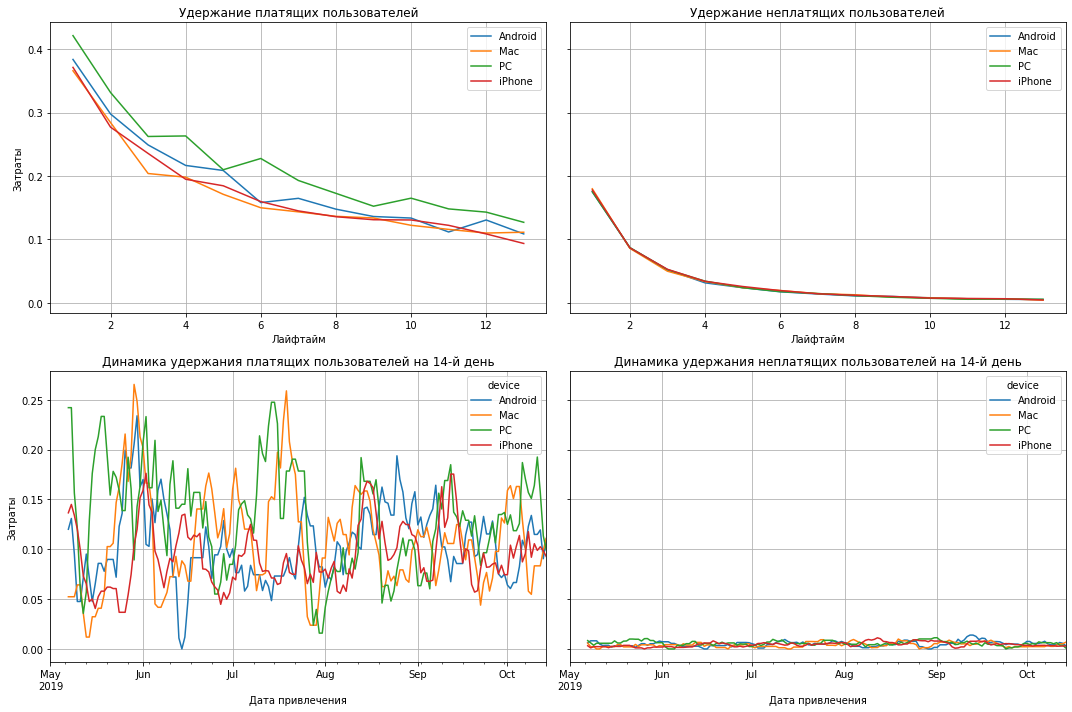

In [50]:
# Удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей выше неплатящих. Значимых различий по устройсвам нет.

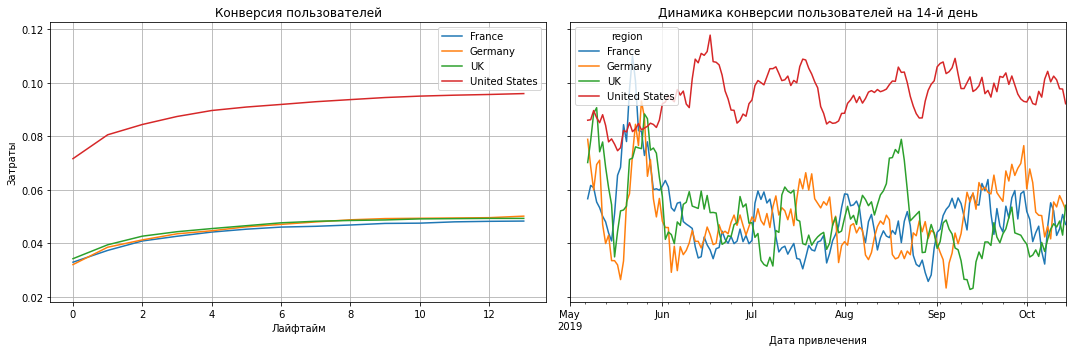

In [51]:
# Конверсия с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Регион США покаывает стабильно лучшие показатели. Остальные страны можно объеденить в однородную группу

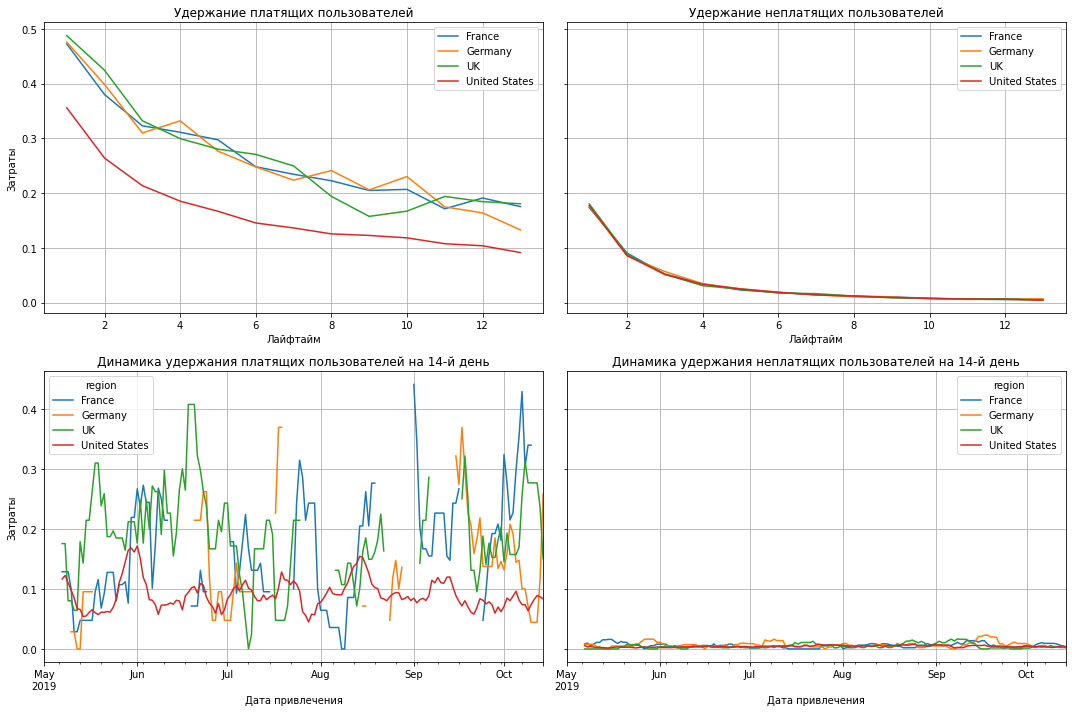

In [52]:
# Удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days)

Платящие пользователи из Америки стабильно хуже удерживаются. Это необходимо лучше изучить. Что может стать одной из точек роста для компании.

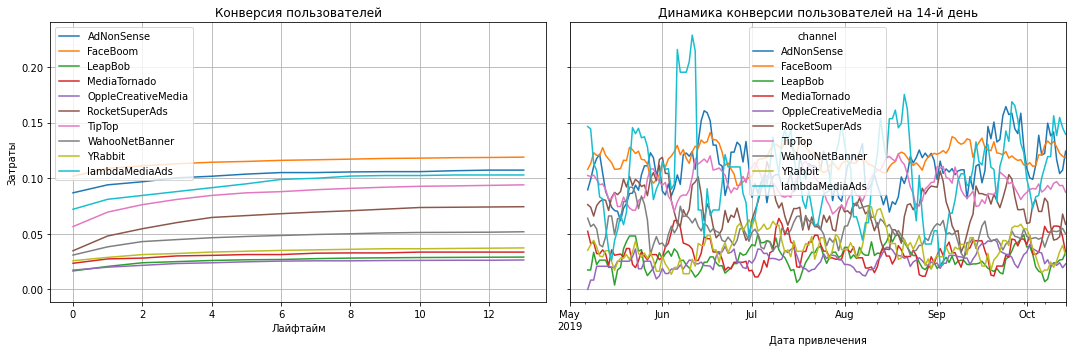

In [53]:
# Конверсия с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия очень неоднородна, лидером является канал FaceBoom с хорошей динамикой на протяжении всего исследуемого периода.

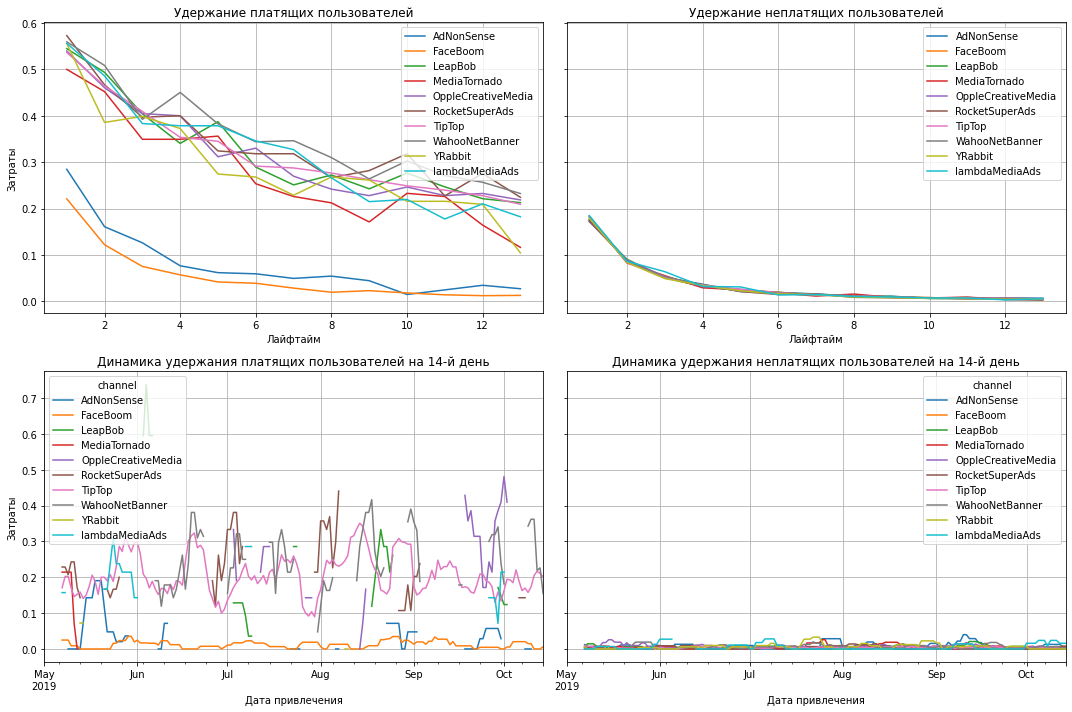

In [54]:
# Удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Плохо удерживаются клиенты, пришедшие из каналов AdNonSense и FaceBoom, практически повторяют динамику удержания для неплатящих пользователей, что очень необычно.  Это может являться еще одной точкой роста для компании, учитывая их высокую конверсию.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

+ В исследовании проанализированы данные по пользователям приложения Procrastinate Pro+ из США, Великобритании, Франции и Германии.
+ США существенно опережают другие страны по количеству пользователей, в т.ч. платящих (всего  100 тыс. чел. 67% ). 
+ iPhonе лидирует среди устройств, занимая самую большую долю. 
+ В основном пользователи пришли в приложение через органический трафик (38% пользователей), FaceBoom (19% пользователей) и TipTop (13% пользователей)
+ TipTop и FaceBoom являются наиболее расходными каналами. Привлечение одного пользователя из канал TipTop обошлось компании в среднем в 2,76 ед., из FaceBoom - 1,11 ед., при этом на TipTop расходы на одного пользователя росли каждый месяц.
+ В целом, реклама в привлечение пользователей не окупилась. 
+ При анализе расходов и окупаемости в разрезе по странам, устройствам и каналам выявлено, что причиной обнаруженных проблем являются чрезмерные расходы на привлечение пользователей.


Выявленые проблемные аспекты снижающие общую окупаемость проекта:
+ Из-за роста стоимости привлечения на одного клиента по каналу TipTop, общая стоисмость привлечения по всему проекту за полгода увеличилась в 1.7 раз и инвестиции, начиная с июня месяца, приносили лишь убытки.
+ Низкая конверсия РС при наиболее высокой окупаемости
+ Пользователи из AdNonSense и FaceBoom имеют очень низкие показатели удержания
+ Платящие пользователи из Америки стабильно хуже удерживаются

Рекомендаций отделу маркетинга приложения Procrastinate Pro+:
+ Снизить затраты на рекламу по каналу TipTop или  отказаться полностью(для принятия решения необходимы дополнителные измерения)
+ Для каналов FaceBoom и AdNonSense снизить бюджет до уровня выхода в планируемые сроки окупаемости(примерно на 25%)
+ Для каналов FaceBoom и AdNonSense изучить проблему отскока пользователей
+ Рынок США является очень привлекательным из-за высокой конверсии и отличной маржинальности клиентов. Однако следует особено внимательно контролировать стоимость привлечения пользователей. Перераспределить бюджет в пользу менее затратных каналов
+ Для рынка Европы исключить/сократить канал AdNonSense
+ Активнее использовать такие каналы  (низкой стоимостью привлечения) как: YRabbit, MediaTomado и RocketSuperAd